# Classification of network flows from Bot-IoT devices using Machine and Deep Learning
## Introduction

The goal of this project is to classify IoT network traffic as malicious (`attack`) or benign (`normal`). It uses the [Bot-IoT dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/bot_iot.php "Bot-IoT dataset"), which aims at being the baseline for allowing botnet identificaiton across IoT-specific networks. It relies on multiple forensics mechanisms, based on machine and deep learning algorithms.

Details of the dataset have been published in the following paper: 
>Nickolaos Koroniotis, Nour Moustafa, Elena Sitnikova, Benjamin Turnbull, “Towards the Development of Realistic Botnet Dataset in the Internet of Things for Network Forensic Analytics: Bot-IoT Dataset”, https://arxiv.org/abs/1811.00701, 2018.

The specificity of this dataset is that its data is strongly imbalanced. To deal with it, various supervised learning algorithms will be used and the results will be compared. Here is an example of confusion matrix from the paper (SVM model):

True\Predict| Normal (0)| Attack (1) |
------------|:---------:|:----------:|
Normal (0)  | 477       |    0       |
Attack (1)  | 426550    | 3241495    |

Several methods exist to deal with this issue such as re-sampling, generating synthetic samples, using anomaly detection methods or producing performance metrics instead of relying on accuracy results. 

In this project, the undersampling method will be implemented to the majority class (attack) and performance metrics such as Precision, Recall, F1 Score and AUC and some anomaly detection methods like one-class SVM and Neural Network will be used to find the best algorithm which highly predicted threatening or normal network flow.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(37) 

import types
from botocore.client import Config
import ibm_boto3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score,\
                            f1_score, roc_auc_score, roc_curve, auc

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import backend as K
import tensorflow as tf
import itertools

from time import time

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


As mentionned in the paper, the columns `pkSeqID`, `proto`, `saddr`, `daddr` and `dport` allow for the identification of the network flow. The next 10 are features which we will use in our models and predictions. We are not interested in the categorical labels (type of attack) in this work. Therefore, we select the features and label of interest for our analysis at import.

In [2]:
feat_keys = ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']
all_keys = feat_keys[:] + ['attack']

In [3]:
feat_keys = ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']

In [4]:
# The code was removed by Watson Studio for sharing.

## 1. Initial Data Exploration

In this part we examine the structure of the data, potential missing values, the features distribution and their relationships with the label value.

### Data structure
First we gather information about the data structure, format and basic statistics.

In [5]:
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
seq,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000
stddev,0.068909,0.000000,0.064494,0.064189,0.063887,0.063579,0.063060,0.062963,0.062906,0.061111
N_IN_Conn_P_SrcIP,75.000000,2.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
min,0.000000,0.000131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
state_number,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.068909,0.000131,0.064494,0.064189,0.063887,0.063579,0.063060,0.062963,0.062906,0.061111
N_IN_Conn_P_DstIP,96.000000,1.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
drate,14.511893,0.000000,15.505319,15.578993,15.652637,15.728587,15.858039,15.882343,15.896735,16.363800
srate,0.566862,0.000000,0.567549,0.567570,0.567630,0.567650,0.567668,0.567692,0.567711,0.568011
max,0.137818,0.000131,0.128988,0.128378,0.127774,0.127157,0.126119,0.125926,0.125812,0.122221


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
seq,3668522.0,121320.416125,75794.283785,1.0,54876.000000,117769.000000,184930.000000,262212.000000
stddev,3668522.0,0.887150,0.803714,0.0,0.030019,0.793896,1.745296,2.496763
N_IN_Conn_P_SrcIP,3668522.0,82.538483,24.397394,1.0,69.000000,100.000000,100.000000,100.000000
min,3668522.0,1.017540,1.483688,0.0,0.000000,0.000000,2.151138,4.980471
state_number,3668522.0,3.134390,1.186971,1.0,3.000000,4.000000,4.000000,11.000000
mean,3668522.0,2.231063,1.517728,0.0,0.181967,2.690125,3.565203,4.981882
N_IN_Conn_P_DstIP,3668522.0,92.451680,18.176435,1.0,100.000000,100.000000,100.000000,100.000000
drate,3668522.0,0.445505,60.288626,0.0,0.000000,0.000000,0.000000,58823.527344
srate,3668522.0,2.955111,724.542476,0.0,0.155970,0.283783,0.488201,1000000.000000
max,3668522.0,3.020015,1.860877,0.0,0.280607,4.009111,4.293582,4.999999


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668522 entries, 0 to 3668521
Data columns (total 11 columns):
seq                  int64
stddev               float64
N_IN_Conn_P_SrcIP    int64
min                  float64
state_number         int64
mean                 float64
N_IN_Conn_P_DstIP    int64
drate                float64
srate                float64
max                  float64
attack               int64
dtypes: float64(6), int64(5)
memory usage: 307.9 MB


### Missing values
We check for missing values.

In [8]:
df.isnull().sum().sum()

0

### Label balance

The last three columns `attack`, `category`and `subcategory`are labels. But we will only use the binary `attack` label in our supervised learning classification. As we can see, the dataset is very imbalanced as per `attack` category:

In [9]:
label_balance = df["attack"].value_counts()
print('Normal: {:8d} flows {:8.3f} %'.format(label_balance[0], 100*label_balance[0]/df.shape[0]))
print('Attack: {:8d} flows {:8.3f} %'.format(label_balance[1], 100*label_balance[1]/df.shape[0]))

Normal:      477 flows    0.013 %
Attack:  3668045 flows   99.987 %


We will need to be cautious with the interpretation of accuracy measure alone, as the accuracy is only reflecting the underlying class distribution (accuracy paradox).

### Feature distribution analysis
We display the distribution of the features in order to see whether some of them need to be transformed.

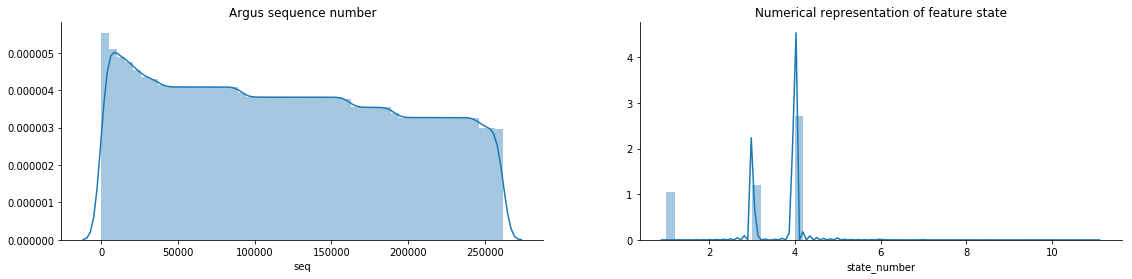

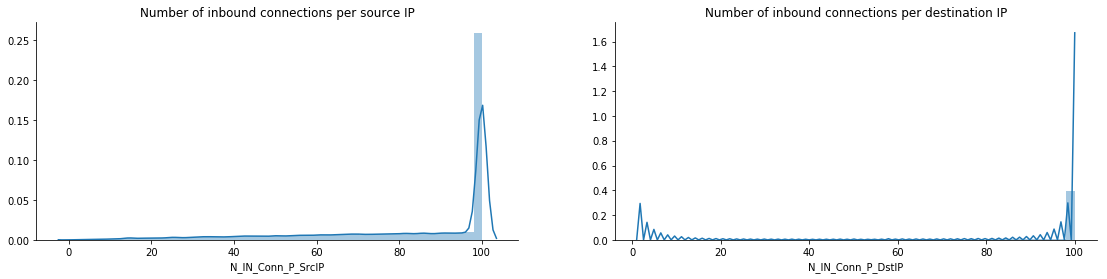

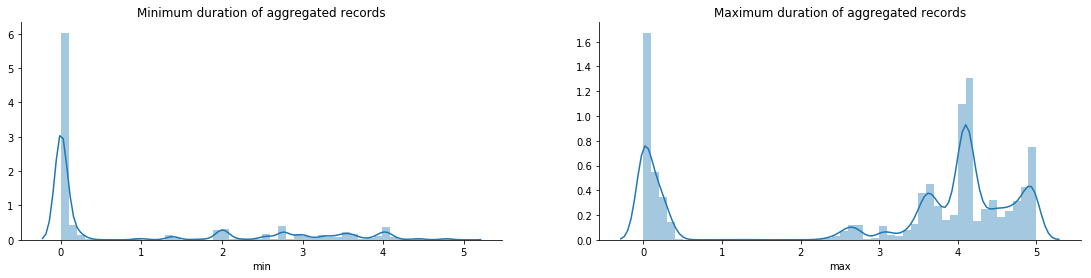

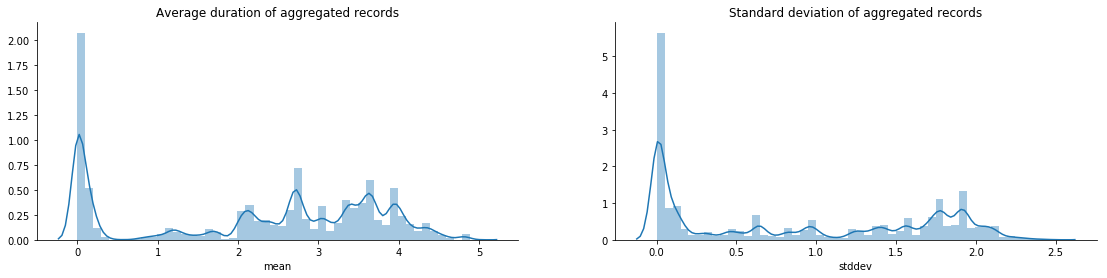

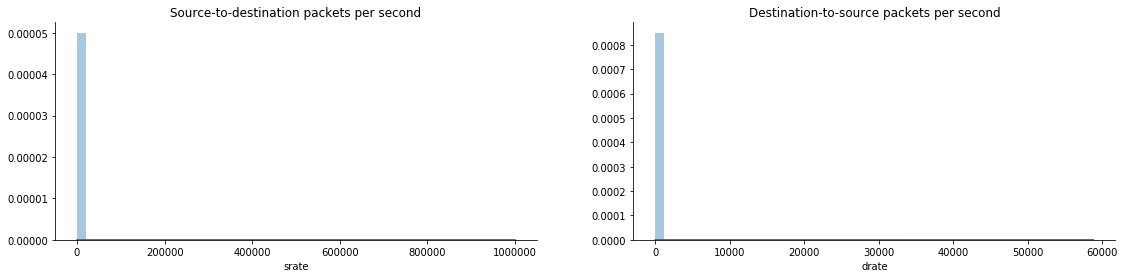

In [10]:
fig, ax1 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['seq'], ax = ax1[0])
ax1[0].set_title("Argus sequence number")
sns.distplot(df['state_number'], ax = ax1[1])
ax1[1].set_title("Numerical representation of feature state")
sns.despine()

fig, ax2 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['N_IN_Conn_P_SrcIP'], ax = ax2[0])
ax2[0].set_title("Number of inbound connections per source IP")
sns.distplot(df['N_IN_Conn_P_DstIP'], ax = ax2[1])
ax2[1].set_title("Number of inbound connections per destination IP")
sns.despine()

fig, ax3 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['min'], ax = ax3[0])
ax3[0].set_title("Minimum duration of aggregated records")
sns.distplot(df['max'], ax = ax3[1])
ax3[1].set_title("Maximum duration of aggregated records")
sns.despine()

fig, ax4 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['mean'], ax = ax4[0])
ax4[0].set_title("Average duration of aggregated records")
sns.distplot(df['stddev'], ax = ax4[1])
ax4[1].set_title("Standard deviation of aggregated records")
sns.despine()

fig, ax5 = plt.subplots(1, 2, figsize=(19, 4))
sns.distplot(df['srate'], ax = ax5[0])
ax5[0].set_title("Source-to-destination packets per second")
sns.distplot(df['drate'], ax = ax5[1])
ax5[1].set_title("Destination-to-source packets per second")
sns.despine()

plt.show()

Above graphs show that `srate` and `drate` are highly right-skewed. We will therefore transform them using a reciprocal function. 

### Outlier identification
We look for outliers in the dataset, using the InterQuartile Range method:

In [11]:
X = df[feat_keys]
all_outliers = np.array([])
for feature in feat_keys:
    Q1 = X[feature].quantile(.25)
    Q3 = X[feature].quantile(.75)
    IQR = float(Q3) - float(Q1)
    outliers = X[((X[feature] <= Q1 - 1.5 * IQR)
                  & (X[feature] >= Q3 + 1.5 * IQR))]
    all_outliers = np.append(all_outliers, np.array(outliers.index.values.tolist()).astype(int))
outlier_count = np.count_nonzero(np.unique(all_outliers))
print('{} outliers were identified, over {} datapoints, which represents {} %.'
      .format(outlier_count,
              df.shape[0],
              round(outlier_count/df.shape[0] * 100, 2)
             )
     )

3574749 outliers were identified, over 3668522 datapoints, which represents 97.44 %.


Since almost all the dataset is detected as outlier, we keep the data as it is.

### **Pearson Correlation Matrix**
In order to analyse correlation between features, we compute a correlation matrix by the Pearson method.

In [12]:
corr=df[feat_keys].corr(method='pearson')

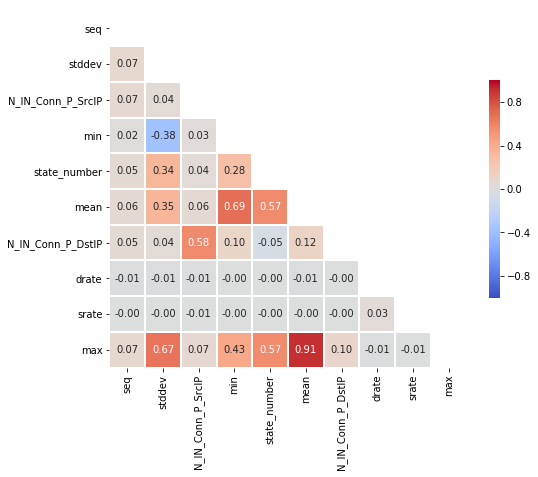

In [13]:
plt.figure(figsize=(8, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            cmap="coolwarm", 
            annot=True, 
            fmt=".2f",
            mask=mask, 
            vmax=1, 
            vmin=-1,
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5})
plt.show()

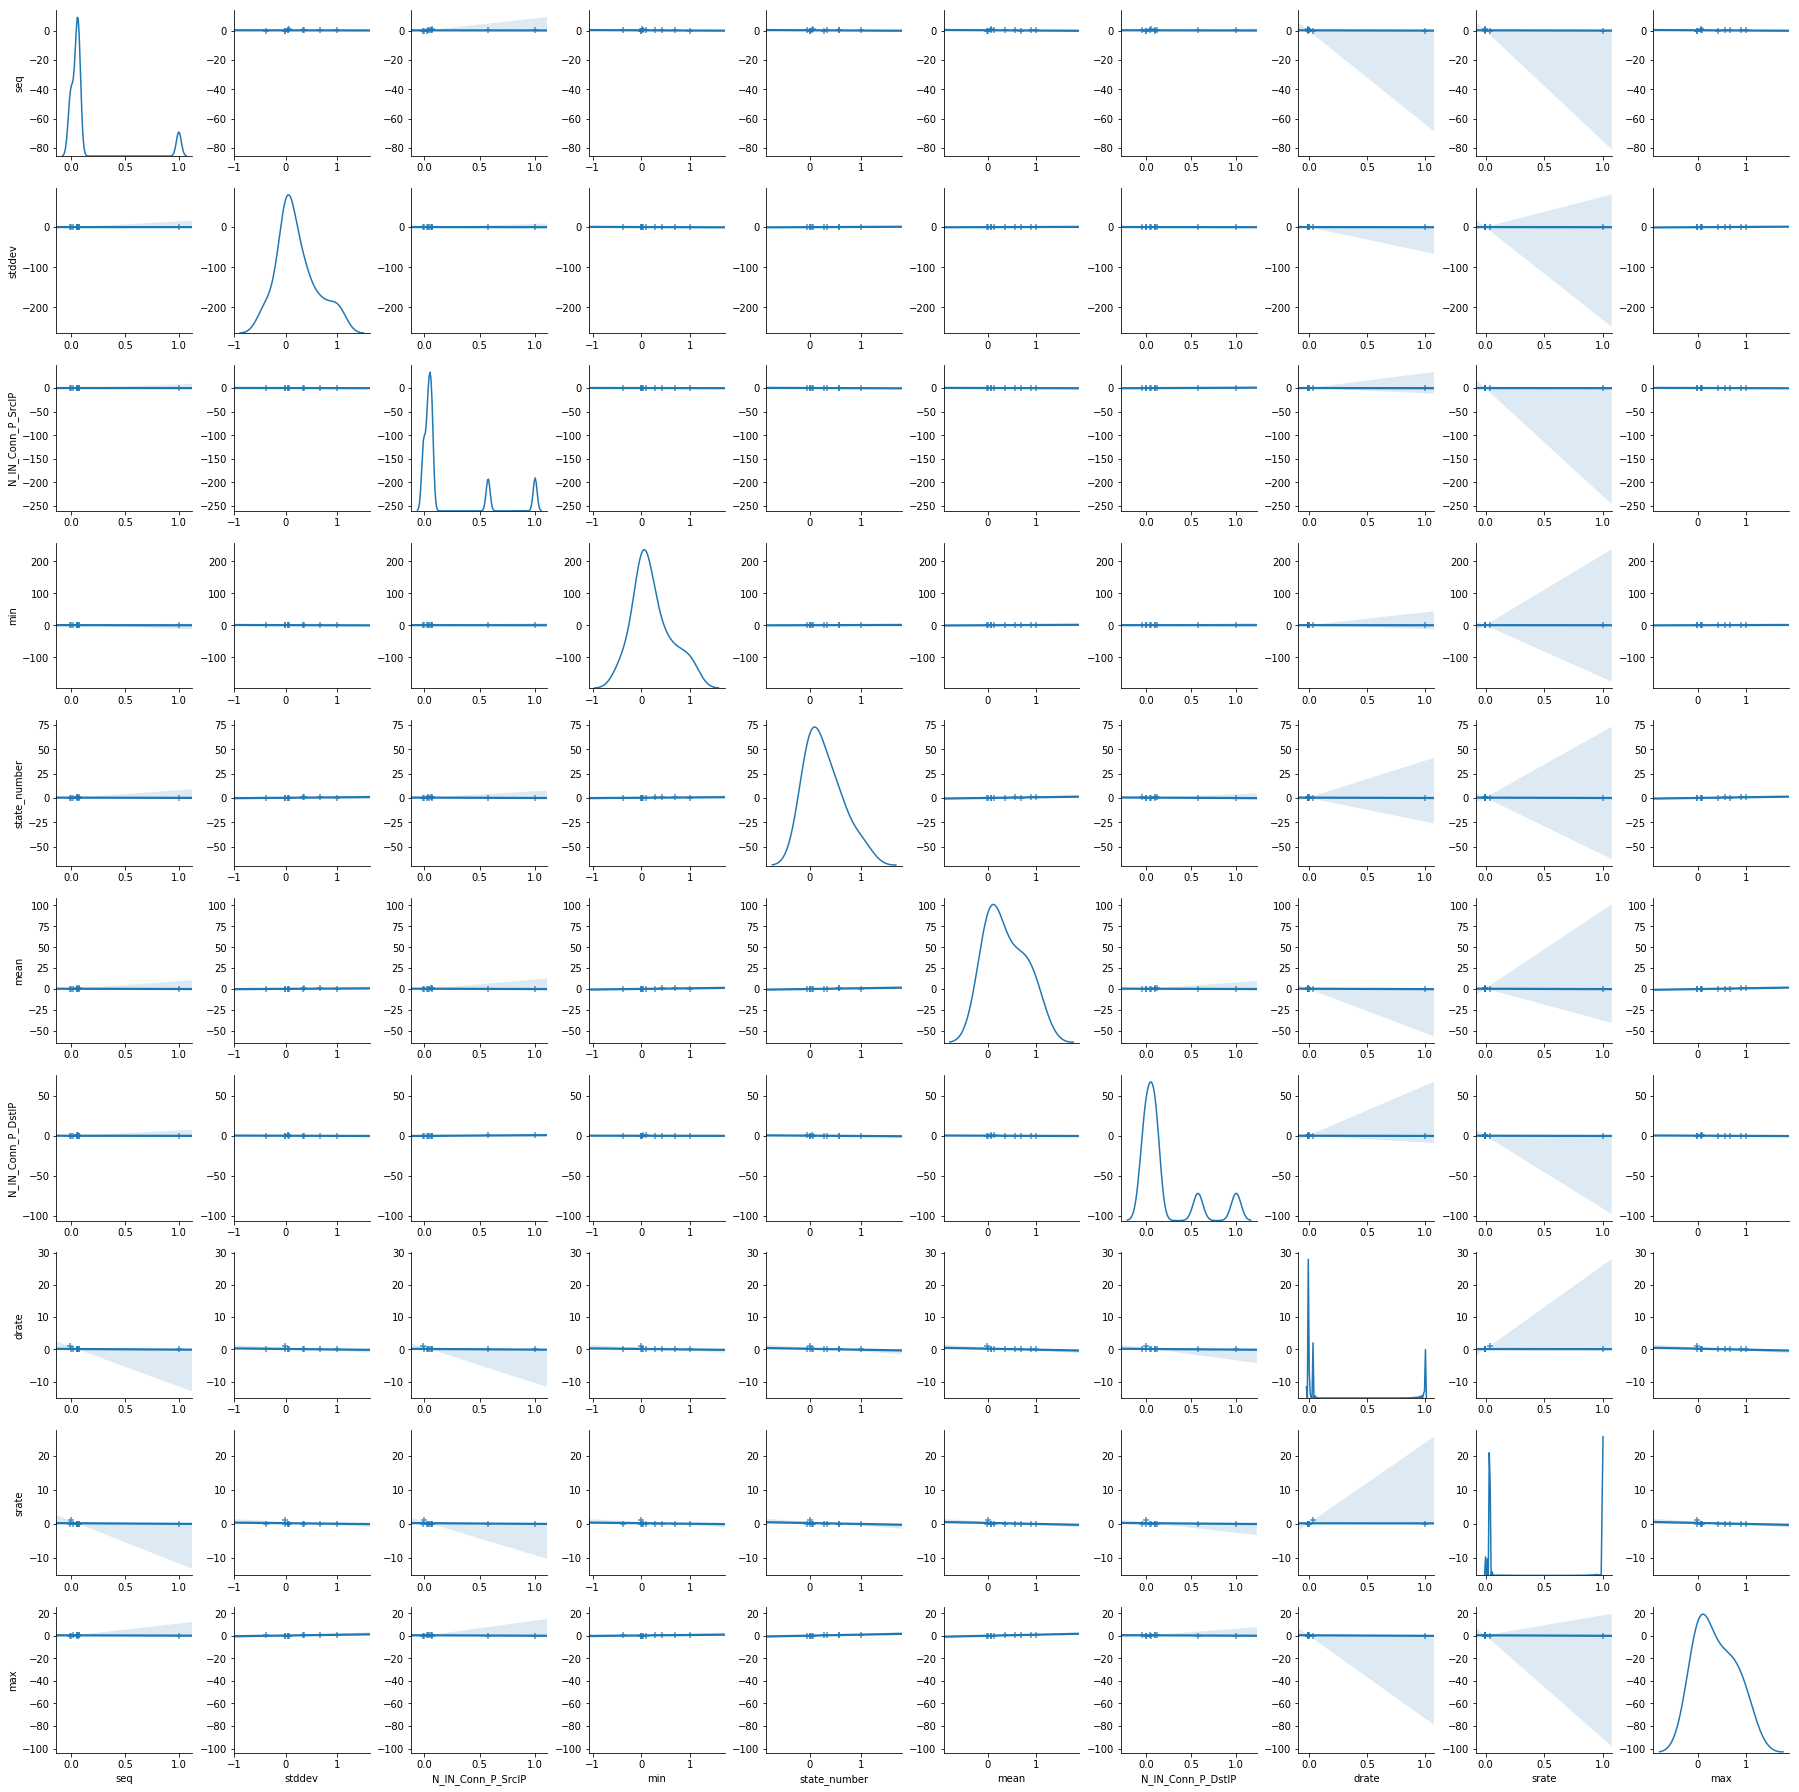

In [14]:
plt.figure(figsize=(8, 8))
sns.pairplot(corr, kind="reg", markers="+", diag_kind="kde")
plt.show()

The Pearson correlation matrix shows overall low correlation between features, except for the `max` feature which has moderate to strong correlation with `state_number` (57%), `stddev` (67%) and `mean` (91%). The two later can be explained, as statistical features (min, max, stddev, mean) are correlated by design. We tried to remove `max` from the features in order to measure the impact on model performance, but the improvement was not significant. Otherwise, these results show that there is no need to take out any feature from model building on the ground of high correlation. 

## 2. ETL and Feature engineering

Before starting with feature selection, we need to transform the dataset into a convenient format for analysis. As most of the extraction and transformation work has already been done by the ADFA team (extraction from PCAP files, some preliminary feature engineering such as mean, min, max, stddev and counts).
Therefore, we directly move to the feature engineering step here.

### Feature transformation
Based on the skewness of data, we apply a reciprocal transformation to `srate` and `drate`

In [15]:
print('Skewness before transformation: {}'.format(df['srate'].skew()))
df['srate'] = df['srate'].apply(lambda x: np.reciprocal(x + 1)) # the +1 avoids null values exceptions
print('Skewness after transformation: {}'.format(df['srate'].skew()))

Skewness before transformation: 919.1096733605993
Skewness after transformation: -1.4767976464969148


In [16]:
print('Skewness before transformation: {}'.format(df['drate'].skew()))
df['drate'] = df['drate'].apply(lambda x: np.reciprocal(x + 1))
print('Skewness after transformation: {}'.format(df['drate'].skew()))

Skewness before transformation: 770.772226120121
Skewness after transformation: -14.920691298918497


### Numerical features normalization with MinMax
Since we are going to use a lot of distance-based methods, in order to avoid some numerical features distances dominate others, we need to scale all of them.

In [17]:
scaler = MinMaxScaler()
df[feat_keys] = scaler.fit_transform(df[feat_keys])

Here is what the transformed features of the dataset look like

In [18]:
df[feat_keys].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
seq,3668522.0,0.462679,0.289058,0.0,0.209278,0.449134,0.705268,1.0
stddev,3668522.0,0.355320,0.321902,0.0,0.012023,0.317970,0.699023,1.0
N_IN_Conn_P_SrcIP,3668522.0,0.823621,0.246438,0.0,0.686869,1.000000,1.000000,1.0
min,3668522.0,0.204306,0.297901,0.0,0.000000,0.000000,0.431915,1.0
state_number,3668522.0,0.213439,0.118697,0.0,0.200000,0.300000,0.300000,1.0
mean,3668522.0,0.447835,0.304649,0.0,0.036526,0.539982,0.715634,1.0
N_IN_Conn_P_DstIP,3668522.0,0.923754,0.183600,0.0,1.000000,1.000000,1.000000,1.0
drate,3668522.0,0.992492,0.054142,0.0,1.000000,1.000000,1.000000,1.0
srate,3668522.0,0.746398,0.166114,0.0,0.671952,0.778948,0.865074,1.0
max,3668522.0,0.604003,0.372176,0.0,0.056121,0.801822,0.858717,1.0


### Dimensionality reduction with Principal Component Analysis and t-SNE
In order to reduce the number of features, we first apply PCA in order to know if a subset of components would keep most of the variance. We then apply t-SNE on a subset of principal components and ultimately visualize in 2D. We define a function to apply PCA to the dataset, since we will use it with different component numbers and input features.

In [19]:
pca = PCA(n_components=10)
df_projected = pca.fit_transform(df[feat_keys])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)

       Explained Variance  Cumulative Variance
PC 1               0.4495               0.4495
PC 2               0.2166               0.6661
PC 3               0.1327               0.7988
PC 4               0.1134               0.9122
PC 5               0.0370               0.9492
PC 6               0.0266               0.9758
PC 7               0.0138               0.9896
PC 8               0.0053               0.9949
PC 9               0.0040               0.9989
PC 10              0.0010               0.9999


We try to visualize the two first principal components, which represent only 67% of the variance

In [20]:
pcaselect_df = pd.DataFrame(data=df_projected[:,:2], columns=[pcs[:2]])

In [21]:
pcaselect_labelled_df = pd.concat([pcaselect_df, df['attack']], axis=1, ignore_index=True)
pcaselect_labelled_df.columns = [*pcs[:2], 'attack']

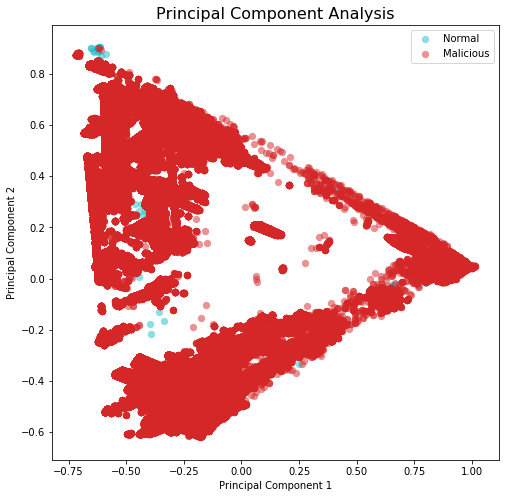

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Principal Component Analysis', fontsize = 16)
targets = [0,1]
colors = ['#17becf', '#d62728']
for target, color in zip(targets,colors):
    indicesToKeep = pcaselect_labelled_df['attack'] == target
    ax.scatter(pcaselect_labelled_df.loc[indicesToKeep, 'PC 1'],\
               pcaselect_labelled_df.loc[indicesToKeep, 'PC 2'],\
               c = color,\
               alpha=0.5,\
               linewidth=0.15,\
               s = 50)
ax.legend(['Normal', 'Malicious'])
plt.show()

We see that normal and malicious flows are overlapping. Therefore we need to increase the number of components we take into account in order to try and isolate normal from malicious flows. We take the first 4 principal components, which account for 91% of the variance.

In [23]:
pcaselect_df = pd.DataFrame(data=df_projected[:,:4], columns=[pcs[:4]])

pcaselect_labelled_df = pd.concat([pcaselect_df, df['attack']], axis=1, ignore_index=True)
pcaselect_labelled_df.columns = [*pcs[:4], 'attack']

We then use these 4 components as input for a t-SNE dimmensionality reduction method. We create dataframes for the features and for the label. The malicious flows are sampled in order to reduce calculation time (it took 1,5 days to produce a visualization with the entire dataset)

In [24]:
df_normal = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 0]
df_malicious  = pcaselect_labelled_df[pcaselect_labelled_df['attack'] == 1].sample(1000)

df_new = df_normal.append(df_malicious).sample(frac=1)
X = df_new[pcs[:4]].values
y = df_new['attack'].values

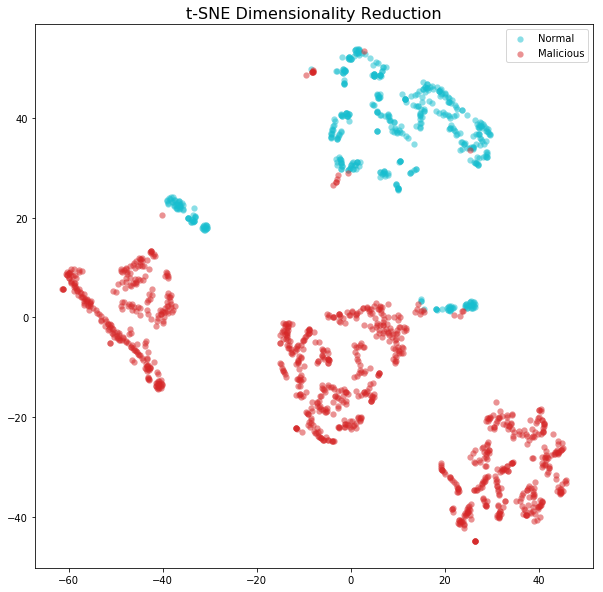

In [25]:
tsne = TSNE(n_components=2, random_state=37)
X_transformed = tsne.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.title("t-SNE Dimensionality Reduction", fontsize = 16)
plt.scatter(X_transformed[y == 0, 0], X_transformed[y == 0, 1], label="Normal", alpha=0.5, linewidth=0.15, c='#17becf')
plt.scatter(X_transformed[y == 1, 0], X_transformed[y == 1, 1], label="Malicious", alpha=0.5, linewidth=0.15, c='#d62728')
plt.legend()
plt.show()

The above graph shows that normal and malicious network flows are not overall clearly separated into two different clusters in the two-dimensional space. 

### Hyperparameter tuning

This last method helps to find the optimal set of parameters to build and run our machine learning and deep learning models. The GridSearch algorithm will be used for the tuning of hyperparameters. Then, we build a XGBoost model to get a list of features ordered by importance. This graph helps to choose parameters which will be used to train the models. 

In [26]:
# First train and label data created. 
train_data, label_data = df.iloc[:,:-1], df.iloc[:,-1]

#Convert to matrix
data_dmatrix = xgb.DMatrix(data=train_data, label= label_data)

In [27]:
#Split data randomly to train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.3, random_state=37)

In [ ]:
grid_param = {'objective':['binary:logistic'],
              'n_estimators': [50, 500],
              'learning_rate': [0.05],
              'min_child_weight': [8, 10, 12],
              'max_depth': [4, 6, 8],
              'seed': [1337]}

# Building Grid Search algorithm with cross-validation and F1 score.
grid_search = GridSearchCV(estimator=XGBClassifier(),
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

In [ ]:
# Lastly, finding the best parameters.

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_  
print(best_parameters)

Based on the result of GridSearch, the following parameters are defined as input to the XGBoost algorithm, to rank features by order of importance. 

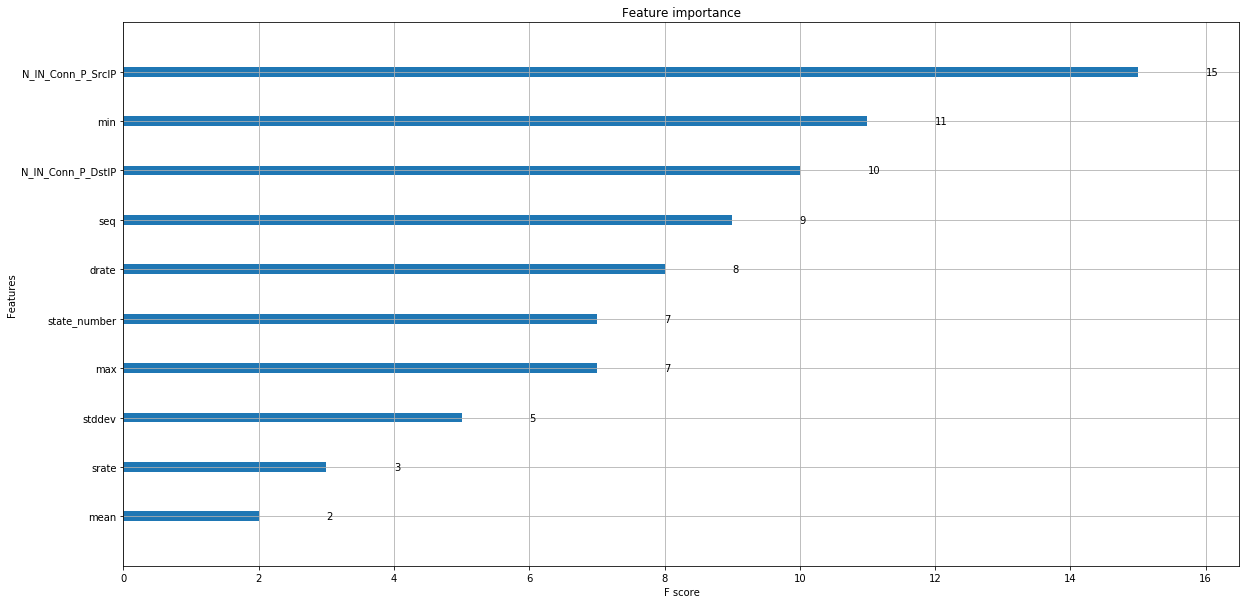

In [28]:
params={
        'objective':'binary:logistic',
        'colsample_bytree': 0.3,
        'learning_rate': 0.05,
        'bootstrap': True, 
        'criterion': 'entropy', 
        'max_depth': 4, 
        'max_features': 'auto', 
        'n_estimators': 50
}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

#Feature importance graph
plt.rcParams['figure.figsize'] = [20, 10]
xgb.plot_importance(xg_reg)
plt.show()

The above plot shows that most important feature is `N_IN_Conn_P_SrcIP` and this feature has a great difference with the other important ones based on f1 score. The feature `mean` has the lowest importance, therefore we eliminate it before building our models. 

In [29]:
df_model = df.drop(['mean'], axis=1)

### Undersampling 
Prior to building the models, we apply undersampling to the data in order to rebalance it slightly.
We use one of the most common ways of dealing with imbalanced data, which is the undersampling method. It decreases the number of datapoints of the dominant label, in our case the `attack` = 1 label. In this project, we retain a sample of 10 000 malicious dataflows. 

In [30]:
data_us_malicious = df_model[df_model['attack'] == 1].sample(10000)
data_us_normal = df_model[df_model['attack'] == 0]
data_us = data_us_malicious.append(data_us_normal, ignore_index=True)

### Data Splitting
The last step of feature engineering before moving to Model Definition consists in splitting the dataset randomly into training and test subsets. The training/test data has already been split by UNSW with a ratio of 80/20.

In [31]:
model_train, model_label = data_us.iloc[:,:-1], data_us.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(model_train, model_label, test_size=0.3, random_state=37)

## 3. Model definition

In this part, we build models for the following supervised learning algorithms: Logistic Regression, Support Vector Machine, Random Forest and Multilayer Perceptron Neural Network.

* We start with Logistic Regression, which is the usual first step in binary classification.
* We then choose Binary Support Vector Machine and Multilayer Perceptron algorithms since they are often used as Anomaly Detection methods and our data is strongly imbalanced.
* Since imbalance data have a tendency to make the model overfit the data, we also pick-up Random Forest in order to mitigate the effect. 

We set the parameter `class_weight` to balanced mode in order to automatically adjust weights according to the label values. This adjustment method will help us get the best recall-precision trade-off.

### Logistic Regression

In [32]:
modelLR = LogisticRegression(
    solver='sag', 
    class_weight='balanced',
    max_iter=500, 
    random_state=37
)

### Support Vector Machine

In [33]:
modelSVM = svm.SVC(
    probability=True,
    max_iter=3000,
    class_weight='balanced',
    kernel='rbf',
    random_state=37
)

### Random Forest

In [34]:
modelRF = RandomForestClassifier(
    n_estimators=500, 
    criterion = 'gini', 
    max_depth = 4, 
    class_weight='balanced', 
    random_state=37
)

### Neural Network - Multilayer Perceptron

In [35]:
modelMLP = MLPClassifier(
    solver='lbfgs', 
    activation='logistic', 
    hidden_layer_sizes=(256,),
    learning_rate='constant', 
    max_iter=500,
    random_state=37
)

### Neural Network - Multilayer Perceptron 2 (with Keras)
As Keras removed all metrics except from Accuracy, we define a Callback function to cumulate metrics such as Recall, Precision and F1 on a per-epoch basis. This is used to produce the confusion matrices.

In [36]:
class SkMetrics(Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []      

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        
        self.confusion.append(confusion_matrix(targ, predict))
        self.precision.append(precision_score(targ, predict))
        self.recall.append(recall_score(targ, predict))
        self.f1s.append(f1_score(targ, predict))

In [37]:
modelMLP2 = Sequential()
modelMLP2.add(Dense(100, activation='relu', input_shape=(9,)))
modelMLP2.add(Dropout(.4))
modelMLP2.add(Dense(1, activation='sigmoid'))
modelMLP2.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

### Neural Network - Multilayer Perceptron 3 (refined with Keras)
This is a more complex Neural Network which structure ressembles the one mentionned in the UNSW paper.

In [38]:
modelMLP3 = Sequential()
modelMLP3.add(Dense(30, activation='relu', input_shape=(9,)))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(40, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(40, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(60, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(80, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(80, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(90, activation='relu'))
modelMLP3.add(Dropout(.6))
modelMLP3.add(Dense(1, activation='sigmoid'))
modelMLP3.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

## 3. Model training

In [39]:
start_time = time()
modelLR.fit(X_train, y_train)
print('Logistic Regression model trained in', round(time() - start_time, 0), 's')

Logistic Regression model trained in 0.0 s


In [40]:
start_time = time()
modelSVM.fit(X_train, y_train)
print('SVM model trained in', round(time() - start_time, 0), 's')

SVM model trained in 1.0 s


In [41]:
start_time = time()
modelRF.fit(X_train, y_train)
print('Random Forest model trained in', round(time() - start_time, 0), 's')

Random Forest model trained in 2.0 s


In [42]:
start_time = time()
modelMLP.fit(X_train, y_train)
print('Multilayer Perceptron model trained in', round(time() - start_time, 0), 's')

Multilayer Perceptron model trained in 97.0 s


For the more complex MLP models based on Keras, we instanciate a sklearn-like metrics. We also define a class_weights dictionary in oder to rebalance the data between classes (there is no pre-defined 'balance' class weight in Keras)

In [43]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)
class_weights_dict = {0 : class_weights_array[0], 1 : class_weights_array[1]}

In [44]:
skmetricsMLP2 = SkMetrics()
start_time = time()
modelMLP2.fit(X_train, y_train, epochs=50, batch_size=25, callbacks=[skmetricsMLP2], class_weight=class_weights_dict,
              validation_data=(X_test, y_test), verbose=0, shuffle=True)
print('Multilayer Perceptron Model 2 trained in', round(time() - start_time), 's')

Multilayer Perceptron Model 2 trained in 62 s


In [45]:
skmetricsMLP3 = SkMetrics()
start_time = time()
modelMLP3.fit(X_train, y_train, epochs=50, batch_size=25, callbacks=[skmetricsMLP3], class_weight=class_weights_dict,
              validation_data=(X_test, y_test), verbose=0, shuffle=True)
print('Multilayer Perceptron Model 3 trained in', round(time() - start_time), 's')

Multilayer Perceptron Model 3 trained in 138 s


## 5. Model prediction and evaluation

In this last part, we predict the model output on the test data. We then assess the quality of our models using various performance metrics. Due to the imbalance in our data, high accuracy scores can be misleading for predictive modeling, therefore we will use a confusion matrix in place of accuracy alone and calculate AUC scores.

The following metrics are employed:

* Confusion Matrix,
* Precision (when an attack is predicted, how often is it legitimate),
* Recall (when an network flow is malicious, how often is it predicted as such),
* F1 Score (the weighted average of the recall and precision),
* AUC (which model proposes the best classification) 

We first obtain predictions from the test data

In [46]:
predict_LR = modelLR.predict(X_test)

In [47]:
predict_SVM = modelSVM.predict(X_test)

In [48]:
predict_RF = modelRF.predict(X_test)

In [49]:
predict_MLP = modelMLP.predict(X_test)

In [50]:
predict_MLP2 = modelMLP2.predict_classes(X_test)

In [51]:
predict_MLP3 = modelMLP3.predict_classes(X_test)

Now we create the confusion matrices and display them

In [52]:
LR_matrix = confusion_matrix(y_test, predict_LR)
SVM_matrix = confusion_matrix(y_test, predict_SVM)
RF_matrix = confusion_matrix(y_test, predict_RF)
MLP_matrix = confusion_matrix(y_test, predict_MLP)
MLP2_matrix = skmetricsMLP2.confusion[0]
MLP3_matrix = skmetricsMLP3.confusion[0]

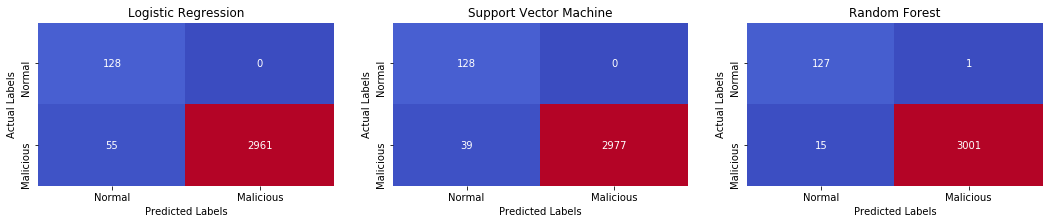

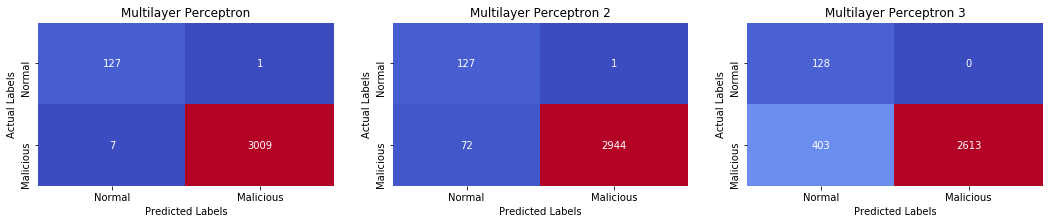

In [53]:
fig, ax1 = plt.subplots(1, 3, figsize=(18, 3))

sns.heatmap(LR_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax1[0])
ax1[0].set_title("Logistic Regression")
ax1[0].set_xlabel('Predicted Labels')
ax1[0].set_ylabel('Actual Labels')
ax1[0].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax1[0].xaxis.set_ticklabels(['Normal', 'Malicious'])

sns.heatmap(SVM_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax1[1])
ax1[1].set_title("Support Vector Machine")
ax1[1].set_xlabel('Predicted Labels')
ax1[1].set_ylabel('Actual Labels')
ax1[1].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax1[1].xaxis.set_ticklabels(['Normal', 'Malicious'])

sns.heatmap(RF_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax1[2])
ax1[2].set_title("Random Forest")
ax1[2].set_xlabel('Predicted Labels')
ax1[2].set_ylabel('Actual Labels')
ax1[2].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax1[2].xaxis.set_ticklabels(['Normal', 'Malicious'])

fig, ax2 = plt.subplots(1, 3, figsize=(18, 3))

sns.heatmap(MLP_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax2[0])
ax2[0].set_title("Multilayer Perceptron")
ax2[0].set_xlabel('Predicted Labels')
ax2[0].set_ylabel('Actual Labels')
ax2[0].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax2[0].xaxis.set_ticklabels(['Normal', 'Malicious'])

sns.heatmap(MLP2_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax2[1])
ax2[1].set_title("Multilayer Perceptron 2")
ax2[1].set_xlabel('Predicted Labels')
ax2[1].set_ylabel('Actual Labels')
ax2[1].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax2[1].xaxis.set_ticklabels(['Normal', 'Malicious'])

sns.heatmap(MLP3_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm", ax = ax2[2])
ax2[2].set_title("Multilayer Perceptron 3")
ax2[2].set_xlabel('Predicted Labels')
ax2[2].set_ylabel('Actual Labels')
ax2[2].yaxis.set_ticklabels(['Normal', 'Malicious'])
ax2[2].xaxis.set_ticklabels(['Normal', 'Malicious'])

plt.show()

In [54]:
print("Classification_LR:")
print(classification_report(y_test, predict_LR))
print("Classification_SVM:")
print(classification_report(y_test, predict_SVM))
print("Classification_RF:")
print(classification_report(y_test, predict_RF))
print("Classification_MLP:")
print(classification_report(y_test, predict_MLP))
print("Classification_MLP2:")
print(classification_report(y_test, predict_MLP2))
print("Classification_MLP3:")
print(classification_report(y_test, predict_MLP3))

Classification_LR:
             precision    recall  f1-score   support

          0       0.70      1.00      0.82       128
          1       1.00      0.98      0.99      3016

avg / total       0.99      0.98      0.98      3144

Classification_SVM:
             precision    recall  f1-score   support

          0       0.77      1.00      0.87       128
          1       1.00      0.99      0.99      3016

avg / total       0.99      0.99      0.99      3144

Classification_RF:
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       128
          1       1.00      1.00      1.00      3016

avg / total       1.00      0.99      1.00      3144

Classification_MLP:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       128
          1       1.00      1.00      1.00      3016

avg / total       1.00      1.00      1.00      3144

Classification_MLP2:
             precision    recall  f1-scor

The above table displays precision, recall, and F1-score results for all models. 

* Logistic Regression model has the highest recall. This means that the Logistic Regression model has a better chance at predicting an actual malicious flow as a such. 
* However, when we look at the precision result, Logistic Regression is one of the lowest results. The highest one achieved with Random Forest. High precision relates to the low false positive rate, so we can say that Random Forest model predict the least false fraudulent transaction. 
* F1-Score gives a better explanation on the grounds that it is calculated from the harmonic mean of Precision and Recall. Especially, the highest recall and lower precision situations. F1 Score is mostly better metrics to choose the best-predicted model. In light of this information, we can say that Random Forest is the best-predicted algorithms in all models. 

## Conclusion

Final comparing will be made with ROC Curve and AUC Score. ROC curve gives a good metric when the detection of both classes is equally important.

In [55]:
#LR AUC
lr_predict_probabilities = modelLR.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_predict_probabilities)
lr_roc_auc = auc(lr_fpr, lr_tpr)
#SVM AUC
svm_predict_probabilities = modelSVM.predict_proba(X_test)[:,1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_predict_probabilities)
svm_roc_auc = auc(svm_fpr, svm_tpr)
#RF AUC
rf_predict_probabilities = modelRF.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_predict_probabilities)
rf_roc_auc = auc(rf_fpr, rf_tpr)
#MLP AUC
mlp_predict_probabilities = modelMLP.predict_proba(X_test)[:,1]
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_predict_probabilities)
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)
#MLP2 AUC
mlp2_predict_probabilities = modelMLP2.predict_proba(X_test)
mlp2_fpr, mlp2_tpr, _ = roc_curve(y_test, mlp2_predict_probabilities)
mlp2_roc_auc = auc(mlp2_fpr, mlp2_tpr)
#MLP3 AUC
mlp3_predict_probabilities = modelMLP3.predict_proba(X_test)
mlp3_fpr, mlp3_tpr, _ = roc_curve(y_test, mlp3_predict_probabilities)
mlp3_roc_auc = auc(mlp3_fpr, mlp3_tpr)

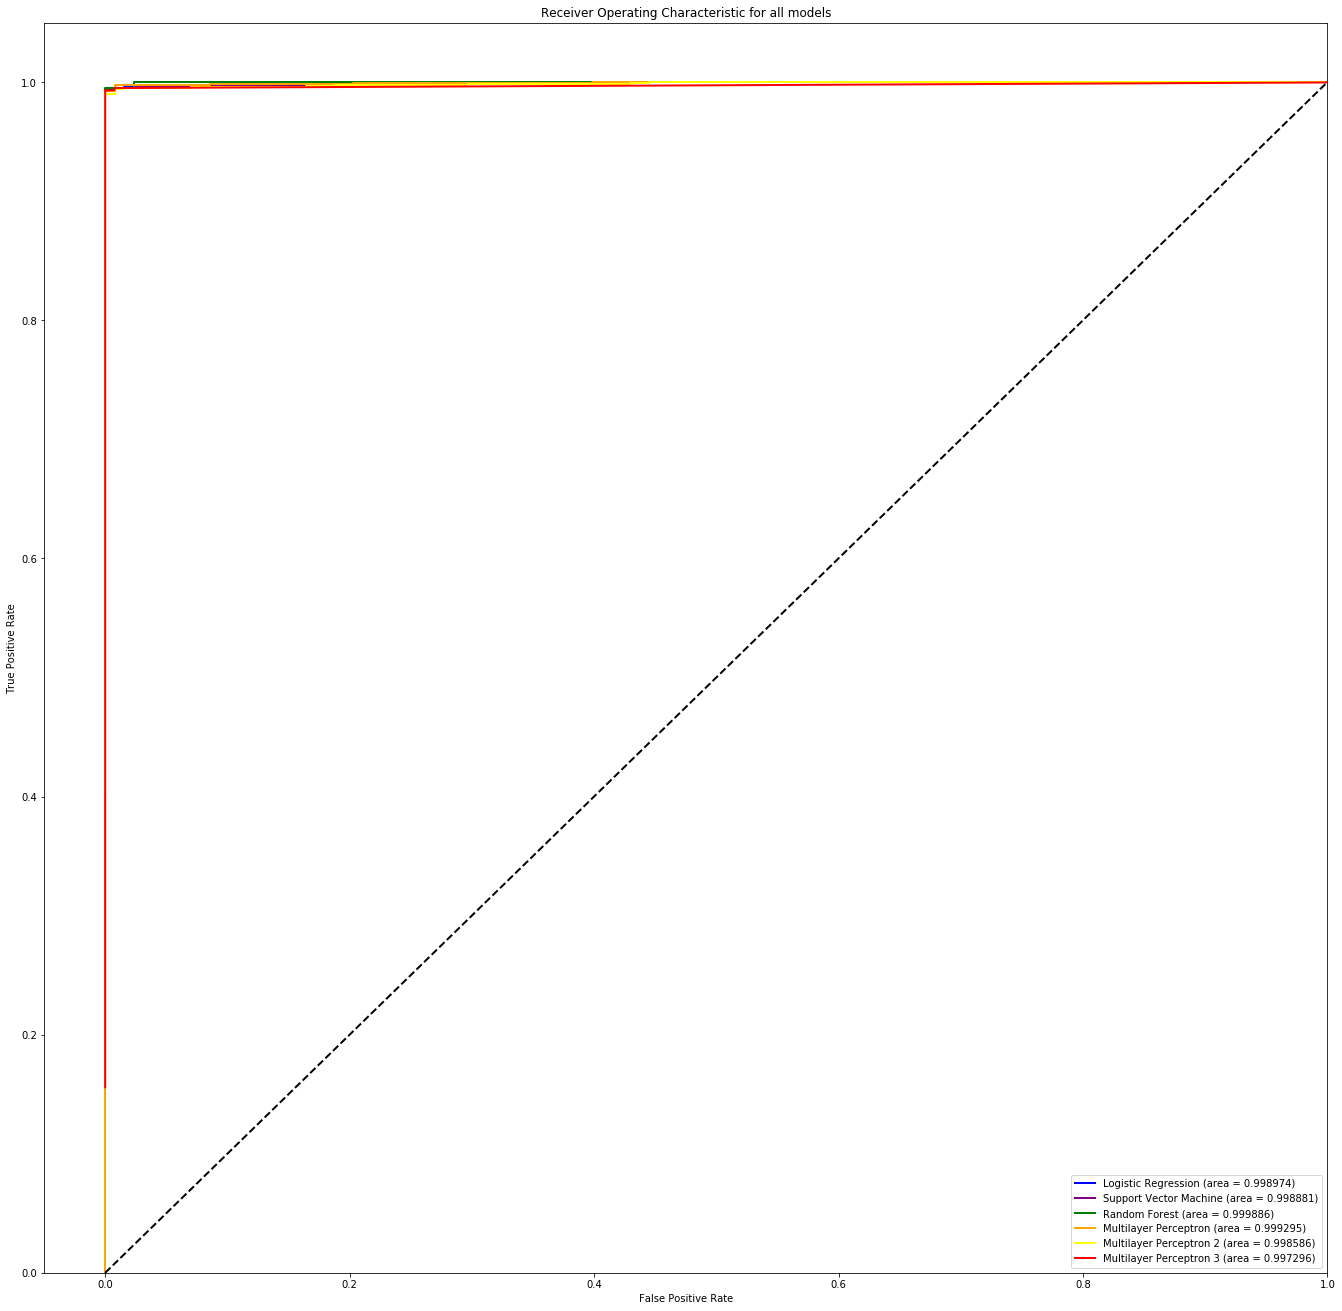

In [56]:
plt.figure(figsize=(23, 23))
plt.title('Receiver Operating Characteristic for all models')
plt.plot(lr_fpr, lr_tpr, color='blue',lw=2, 
         label='Logistic Regression (area = %0.6f)' % lr_roc_auc)
plt.plot(svm_fpr, svm_tpr, color='purple',lw=2, 
         label='Support Vector Machine (area = %0.6f)' % svm_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='green',lw=2,
         label='Random Forest (area = %0.6f)' % rf_roc_auc)
plt.plot(mlp_fpr, mlp_tpr, color='orange',lw=2, 
         label='Multilayer Perceptron (area = %0.6f)' % mlp_roc_auc)
plt.plot(mlp2_fpr, mlp2_tpr, color='yellow',lw=2, 
         label='Multilayer Perceptron 2 (area = %0.6f)' % mlp2_roc_auc)
plt.plot(mlp3_fpr, mlp3_tpr, color='red',lw=2, 
         label='Multilayer Perceptron 3 (area = %0.6f)' % mlp3_roc_auc)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

Based on the above ROC curves and confusion matrices, we can see that Random Forest, then Multilayer Perceptron, followed by SVM and Logistic Regression algorithms perform well.
We could expand the analysis to multi-class classification in order to detect to what kind of attack a network flow belongs to. This could be done either with supervised or unsupervised learning. 